In [1]:
# Every time you run a a Zipline backtest, you need to import run_algorithm from zipline
# We also need a few things from the zipline.api. What we import will depend on what you want to do in the backtest

# This ensures that our graphs will be shown properly in the notebook
%matplotlib inline

# Import Zipline functions that we need
from zipline import run_algorithm
from zipline.api import order_target_percent, symbol

# Import data and time zone libraries
from datetime import datetime
import pytz

# Import visualization
import matplotlib.pyplot as plt

In [2]:
# Most algorithms will have three functions; intialize(), handle_data(), and analyze()

# initialize() function essentially sets up the backtesting environment
def initialize(context):
    # which stock to trade
    context.stock = symbol('AAPL')
    
    # moving average window
    context.index_average_window = 100

In [3]:
# handle_data() function is where the trading logic goes (i.e. when/how much to buy/sell). 
# If we are dealing with daily data, then we will need to call handle_data() once per day etc.
# The first thing we do in handle_data() is to pull time series history
def handle_data(context, data):
    # Request history for the stock (setting up the historical data). The history() pulls historical data from a symbol
    # the first argument is the stock(either a single stock or multiple depending on what we defined context.stock to be in the inifialize function)
    # the second argument is the field ("close", "open", "high" etc. This could be a single field or an array of fields
    # the third argument is how many data points we want. in this case it is 100 based on how we set it up in intialize()
    # the fourth argument is the frequency
    equities_hist = data.history(context.stock, "close", context.index_average_window, "1d")
    
    # Trading logic (i.e. long if price goes above moving average, else flat)
    # Check if price is above moving average. To represent the last closing price, we get the last price designated bu -1 and
    # compare to the average(mean) of the whole equities_hist
    if equities_hist[-1] > equities_hist.mean():
        stock_weight = 1.0
    else:
        stock_weight = 0.0
            
    # execute trade order
    order_target_percent(context.stock, stock_weight)

In [4]:
# analyze() is called after the backest is performed and is responsible for calculateing analytics and visualizing results
def analyze(context, perf):
    fig = plt.figure(figsize=(12, 8))
    
    # First chart
    ax = fig.add_subplot(311)
    ax.set_title('Strategy Results')
    ax.semilogy(perf['portfolio_value'], linestyle='-', label='Equity Curve', linewidth=3.0)
    ax.legend()
    ax.grid(False)

    # Second subplot
    ax = fig.add_subplot(312)
    ax.plot(perf['gross_leverage'], label='Exposure', linestyle='-', linewidth=1.0)
    ax.legend()
    ax.grid(True)

    # Third subplot
    ax = fig.add_subplot(313)
    ax.plot(perf['returns'], label='Returns', linestyle='-', linewidth=1.0)
    ax.legend()
    ax.grid(True)

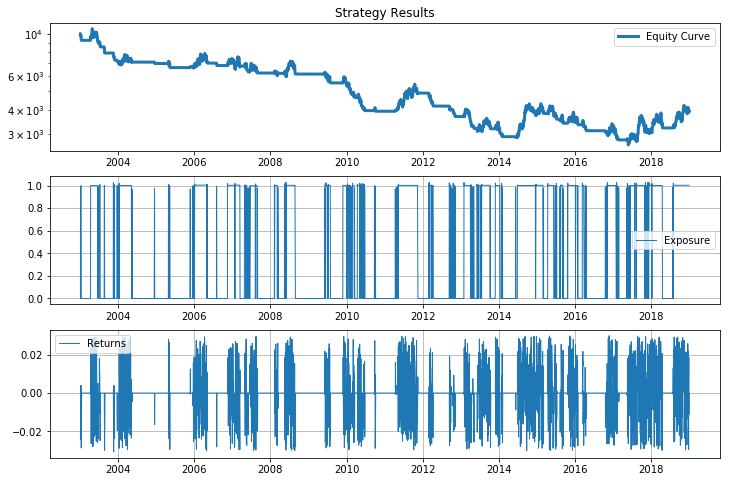

In [7]:
# Set start and end date
start_date = datetime(2003, 1, 1, tzinfo=pytz.UTC)
end_date = datetime(2018, 12, 31, tzinfo=pytz.UTC)

# First off the backtest
results = run_algorithm(
    start=start_date,
    end=end_date,
    initialize=initialize,
    analyze=analyze,
    handle_data=handle_data,
    capital_base=10000,
    data_frequency='daily',
    bundle='random_stock_data'
)